# RFM
- **Months_Inactive_12_mon**: a proxy for Recency. This column could indicate how many months have passed since the customer's last active engagement. A lower number of 'Inactive_Months' would imply more recent activity.

- **Total_Trans_Ct**: a good indicator of transaction frequency over a given period. This could include all types of transactions such as deposits, withdrawals, payments, etc.

- **Total_Trans_Amt**:  how much money is being transacted. ('Credit_Limit' might reflect the potential revenue or value of the customer, 'Revolving_balance' could indicate how much the customer typically borrows)

Importance: Recency > Frequency >> Monetary (not valueable)

Reason: 
- Churn Focus: In the context of churn analysis, the focus might be more on identifying patterns or behaviors that precede account closure or inactivity, rather than on maximizing revenue from each customer. While transaction amounts can indicate customer value, they might not provide insights into why customers are leaving, which is a primary concern in churn analysis.

- Data Interpretation Challenges: Large transaction amounts don't necessarily equate to high customer value in a banking context. A few large transactions could be less valuable than many smaller, regular transactions, which indicate a higher level of customer engagement and loyalty.

- Different customers may have different cash back based on their credit card services. 

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('BankChurners.csv')
df

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.999940
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.996710,0.003294


In [15]:
df.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

In [2]:
rfm = df.groupby('CLIENTNUM').agg({
    'Months_Inactive_12_mon':'sum', # Recency in months
    'Total_Trans_Ct': 'sum'                                    # Frequency
    #'Trans_Amount': 'sum' ,                                    # Monetary
      # Tenure: 'InvoiceDate': lambda x: (snapshot_date - x.min()).days
})

rfm.rename(columns={'Months_Inactive_12_mon': 'Recency', 'Total_Trans_Ct': 'Frequency'}, inplace=True)

In [33]:
# Function to dynamically assign quartiles with correct number of labels
def assign_inverted_quartiles(series):
    # Attempt to divide into quartiles, handling duplicates by dropping them
    try:
        quartiles = pd.qcut(series, q=4, duplicates='drop')
        unique_bins = len(quartiles.cat.categories)
        
        # Generate inverted labels based on the number of unique bins available
        bin_labels = range(unique_bins, 0, -1)
        quartiles = pd.qcut(series, q=4, duplicates='drop', labels=bin_labels)
    except ValueError as e:
        print(f"Error assigning quartiles: {e}")
        quartiles = pd.Series([None] * len(series))  # Assign None for error cases

    return quartiles

def assign_quartiles(series, labels=True):
    try:
        quartiles = pd.qcut(series, q=4, duplicates='drop')
        unique_bins = len(quartiles.unique())
        
        if labels:
            bin_labels = range(1, unique_bins + 1)
            quartiles = pd.qcut(series, q=4, duplicates='drop', labels=bin_labels)
    except ValueError as e:
        print(f"Error assigning quartiles: {e}")
        quartiles = pd.Series([None] * len(series))
    
    return quartiles

rfm['R'] = assign_inverted_quartiles(rfm['Recency']) # reverse score
rfm['F'] = assign_quartiles(rfm['Frequency'])
rfm['R'] = rfm['R'].astype(int)
rfm['F'] = rfm['F'].astype(int)
# alternative weighted score: 
rfm["RFM_Score"] = 0.7*rfm['R'] + 0.3*rfm['F'] 
rfm

,Recency,Frequency,R,F,RFM_Score,RFM_Segment,Cluster
CLIENTNUM,,,,,,,
708082083,3,111,2,4,2.6,Medium,2
708083283,1,21,3,1,2.4,Medium,3
708084558,3,23,2,1,1.7,Low,1
708085458,2,82,3,4,3.3,High,0
708086958,5,59,1,2,1.3,Low,1
...,...,...,...,...,...,...,...
828288333,1,70,3,3,3.0,High,0
828291858,3,40,2,1,1.7,Low,1
828294933,2,36,3,1,2.4,Medium,3


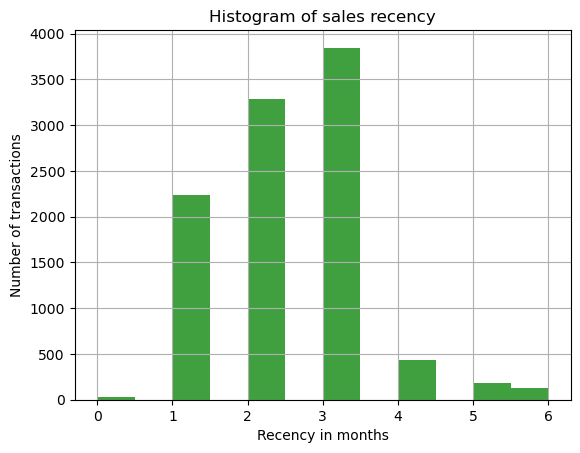

In [34]:
# recency
import math
x = rfm.Recency
mu = np.mean(rfm.Recency)
sigma = math.sqrt(np.var(rfm.Recency))
n, bins, patches = plt.hist(x, 12, facecolor='green', alpha=0.75)
plt.xlabel('Recency in months')
plt.ylabel('Number of transactions')
plt.title(r'Histogram of sales recency')
plt.grid(True)
# Recency=3 has the highest amount (3 inactive months)
# most data are <=3 recency (good sign?)

In [35]:
rfm["RFM_Score"].value_counts()

RFM_Score
3.0    1473
3.3    1377
2.4    1370
2.7    1324
1.7    1041
2.0    1010
2.3     983
2.6     812
1.6     206
1.0     200
1.3     178
1.9     153
Name: count, dtype: int64

In [36]:
# humanization
bins = [0, 2.1, 2.7, 3.2, 3.4]
labels = ['Low', 'Medium', 'High', 'Very High']
rfm['RFM_Segment'] = pd.cut(rfm['RFM_Score'], bins=bins, labels=labels)
rfm

,Recency,Frequency,R,F,RFM_Score,RFM_Segment,Cluster
CLIENTNUM,,,,,,,
708082083,3,111,2,4,2.6,Medium,2
708083283,1,21,3,1,2.4,Medium,3
708084558,3,23,2,1,1.7,Low,1
708085458,2,82,3,4,3.3,Very High,0
708086958,5,59,1,2,1.3,Low,1
...,...,...,...,...,...,...,...
828288333,1,70,3,3,3.0,High,0
828291858,3,40,2,1,1.7,Low,1
828294933,2,36,3,1,2.4,Medium,3


# Attrition

In [43]:
rfm_df = pd.merge(rfm, df, on='CLIENTNUM',how='inner')
segments = ['Low', 'Medium', 'High', 'Very High']

for segment in segments:
    subset = rfm_df[rfm_df['RFM_Segment'] == segment]
    
    attrited = subset[subset['Attrition_Flag'] == 'Attrited Customer'].count()[0] 
    existed = subset[subset['Attrition_Flag'] == 'Existing Customer'].count()[0]  
    perc = round(attrited / (attrited+existed)*100, 2)
    
    print(f"RFM_Segment: {segment}, Attrited: {attrited}, Existed: {existed}, Proportion: {perc}%")
    
# under each sgement level we designed, what's the proportion of attrited vs. existed (true labels)?
# very high level, small portion of existed (lower attrition)
# as it goes low, number of attrition increases (esp for low and medium)

RFM_Segment: Low, Attrited: 926, Existed: 1862, Proportion: 33.21%
RFM_Segment: Medium, Attrited: 648, Existed: 3841, Proportion: 14.44%
RFM_Segment: High, Attrited: 45, Existed: 1428, Proportion: 3.05%
RFM_Segment: Very High, Attrited: 8, Existed: 1369, Proportion: 0.58%


RFM Segment: Low
- This segment has a relatively high attrition rate compared to its size. The number of customers who have left (attrited) is significant, indicating that customers in the "Low" RFM segment are at a higher risk of churn. This might be due to low engagement, infrequent transactions, or recent inactivity.

RFM Segment: Medium
- Although the number of attrited customers is less than in the "Low" segment, the "Medium" segment includes the highest number of existing customers. This suggests that while there's a better retention rate than the "Low" segment, there's still room for improvement to move these customers to higher segments and reduce attrition further.

RFM Segment: High
- The "High" RFM segment shows a significant decrease in attrition, indicating that customers with higher engagement levels, more frequent transactions, or recent activity are much less likely to leave. This segment represents a relatively loyal or satisfied customer base.

RFM Segment: Very High
- The "Very High" segment shows the lowest number of attrited customers, suggesting extremely strong customer loyalty or satisfaction within this group. These customers are likely the most engaged, with the highest transaction frequency or the most recent interactions with the business.

In [38]:
rfm_df['RFM_Segment'].value_counts()

RFM_Segment
Medium       4489
Low          2788
High         1473
Very High    1377
Name: count, dtype: int64

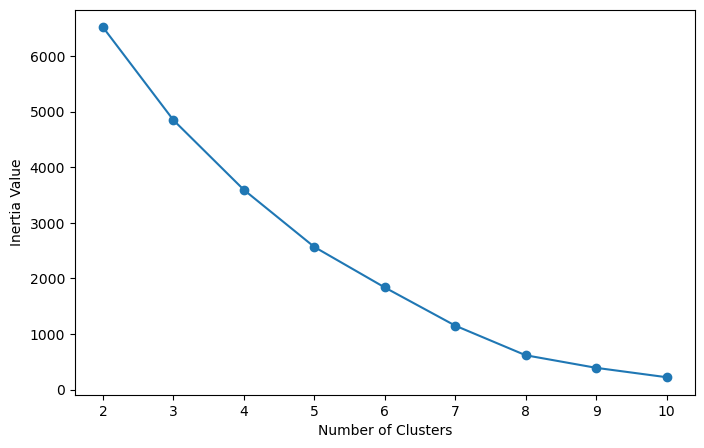

In [44]:
# Cluster the data based on R F categories. Could we use a more elaborate clustering scheme ?
import math
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from scipy.stats import norm
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import missingno as msno

X = rfm[['R','F']]
n_cluster = range(2,11,1)
cost = []

for i in n_cluster:
    model = KMeans(n_clusters=i, random_state=13)
    model.fit(X)
    cost.append(model.inertia_)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(n_cluster, cost, marker="o")
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Inertia Value")
plt.show()

In [48]:
#k=5 gets better clusters, however take inputs from the business
model = KMeans(n_clusters=5, init='k-means++',random_state=2024)
y = model.fit_predict(X)

rfm['Cluster'] = y
rfm

,Recency,Frequency,R,F,RFM_Score,RFM_Segment,Cluster
CLIENTNUM,,,,,,,
708082083,3,111,2,4,2.6,Medium,3
708083283,1,21,3,1,2.4,Medium,2
708084558,3,23,2,1,1.7,Low,0
708085458,2,82,3,4,3.3,Very High,1
708086958,5,59,1,2,1.3,Low,0
...,...,...,...,...,...,...,...
828288333,1,70,3,3,3.0,High,4
828291858,3,40,2,1,1.7,Low,0
828294933,2,36,3,1,2.4,Medium,2


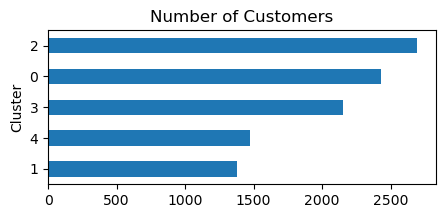

In [53]:
#group by topic and plot rows in the descending order
rfm.groupby('Cluster').size().sort_values(ascending=True)\
    .plot(title="Number of Customers", kind='barh',figsize=(5,2))
plt.show()

In [68]:
# cluster analysis
rfm_cluster = pd.merge(rfm, df, on='CLIENTNUM',how='inner')
cluster_summary = rfm_cluster.groupby('Cluster').agg({
    'Recency': ['mean', 'min', 'max'],
    'Frequency': ['mean', 'min', 'max'],
    'Credit_Limit': 'mean',
    'Avg_Open_To_Buy':'mean',
    'Total_Revolving_Bal':'mean',
    'Avg_Utilization_Ratio':'mean',
    'RFM_Segment': lambda x: x.mode()[0] if not x.mode().empty else None, # the most common level in the cluster
    'Attrition_Flag': lambda x: (x == 'Attrited Customer').sum(), # Count of attrited customers
}).reset_index()
cluster_summary
# attrition: 1 > 3 > 2 > 0 (match our expectation of assigning different levels based on RF)
# clustering doing well in attrition for low and medium segment
# Cluster 2 has the highest amount of attrited customers: which has the higher recency (inactive months) and lower frequency and lower credit limit

Cluster   Recency          Frequency           Credit_Limit Avg_Open_To_Buy  \
               mean min max       mean min  max          mean            mean   
0       0  3.232194   3   6  45.901194  10   67   8340.441046     7253.245080   
1       1  1.569354   0   2  95.104575  82  138  10137.774001     8881.357153   
2       2  1.601707   0   2  46.125835  10   67   8770.724016     7601.014662   
3       3  3.278087   3   6  83.692201  68  139   8539.255896     7362.487558   
4       4  1.575696   0   2  74.565513  68   81   7586.735438     6419.744942   

  Total_Revolving_Bal Avg_Utilization_Ratio RFM_Segment Attrition_Flag  
                 mean                  mean    <lambda>       <lambda>  
0         1087.195965              0.256716         Low            915  
1         1256.416848              0.265763   Very High              8  
2         1169.709354              0.263795      Medium            567  
3         1176.768338              0.289722      Medium             92  
4         1166.990496              0.312018        High             45

In [60]:
rfm_cluster.columns

Index(['CLIENTNUM', 'Recency', 'Frequency', 'R', 'F', 'RFM_Score',
       'RFM_Segment', 'Cluster', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

**Cluster 0** stands out as having both the most recent and the most frequent interactions with the company, paired with a "High" RFM segment classification, which suggests strong customer engagement.

**Cluster 1** has moderate recency and the lowest frequency of interactions, coupled with the highest attrition rate and a "Low" RFM segment classification, indicating a critical segment that may require immediate attention to improve customer retention.

**Cluster 2** shows a profile similar to Cluster 0 in terms of interaction frequency but has a higher recency average, and a "Medium" RFM segment classification, which suggests a potential for moving customers to a higher segment with targeted engagement strategies.

**Cluster 3** has recent interactions and a moderate frequency, yet it exhibits a significant number of attritions, highlighting a paradox where recent interaction does not necessarily equate to loyalty or customer satisfaction.

Targeting Strategy:

**High RFM (Low Recency, High Frequency)**:
Strategy: Focus on loyalty and retention programs. Customers in this segment are engaged and active. Offer loyalty rewards, membership perks, and exclusive access to new products or services to encourage continued patronage.

**Medium RFM (Moderate Recency and Frequency)**:
Strategy: Engage with targeted marketing campaigns to increase frequency. Provide incentives such as limited-time offers or personalized recommendations based on past purchases to encourage more frequent interactions.

**Low RFM (High Recency, Low Frequency)**:
Strategy: Implement re-engagement campaigns. These customers are at risk of churning, so you might consider win-back offers, feedback surveys to understand their lack of engagement, or product/service improvements based on customer insights.

In [69]:
# Count the number of data points in each cluster
cluster_counts = rfm['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']
cluster_counts

,Cluster,Count
0,2,2694
1,0,2429
2,3,2154
3,4,1473
4,1,1377


In [70]:
# centroids' stat
centers = pd.DataFrame(model.cluster_centers_, columns=['Recency', 'Frequency'])
centers['Cluster'] = centers.index
centers

,Recency,Frequency,Cluster
0,1.844380,1.489090,0
1,3.000000,4.000000,1
2,3.000000,1.491463,2
3,1.833333,3.448004,3
4,3.000000,3.000000,4
